In [2]:
# Importing necessary libraries to unzip `tiny-imagenet-200.zip`
import os
import zipfile
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [3]:
# Unzip the dataset
with zipfile.ZipFile("tiny-imagenet-200.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
# Lets see the directory structure of tiny-imagenet-200
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        jpeg_files = [f for f in files if f.endswith('.JPEG')]
        if jpeg_files:  # if the list is not empty
            print('{}Number of JPEG files: {}'.format(subindent, len(jpeg_files)))
        for f in files:
            if f.endswith('.txt'):
                print('{}{}'.format(subindent, f))

list_files('tiny-imagenet-200')

tiny-imagenet-200/
    wnids.txt
    words.txt
    test/
        images/
            Number of JPEG files: 10000
    train/
        n01443537/
            n01443537_boxes.txt
            images/
                Number of JPEG files: 500
        n01629819/
            n01629819_boxes.txt
            images/
                Number of JPEG files: 500
        n01641577/
            n01641577_boxes.txt
            images/
                Number of JPEG files: 500
        n01644900/
            n01644900_boxes.txt
            images/
                Number of JPEG files: 500
        n01698640/
            n01698640_boxes.txt
            images/
                Number of JPEG files: 500
        n01742172/
            n01742172_boxes.txt
            images/
                Number of JPEG files: 500
        n01768244/
            n01768244_boxes.txt
            images/
                Number of JPEG files: 500
        n01770393/
            n01770393_boxes.txt
            images/
              

In [5]:
# Path and Files
path = './tiny-imagenet-200/train/'
wnid_labels = dict(line.strip().split('\t') for line in open('./tiny-imagenet-200/words.txt'))  # Corrected path
dirs = os.listdir(path)

# Read the wnids from wnids.txt into a set
with open('./tiny-imagenet-200/wnids.txt') as f:
    wnids = {line.strip() for line in f}

# Filter wnid_labels to only include the wnids in Tiny ImageNet
wnid_labels = {wnid: desc for wnid, desc in wnid_labels.items() if wnid in wnids}

len(wnid_labels) # We only want the mappings that are in tinynet

200

In [6]:
# Define the function to randomly sample n images
def rsample_images(n):
    """
    Sample n random images from the train directory along with their English wnid representations and bounding boxes.

    Args:
    n (int): The number of images to sample.

    Returns:
    List[Tuple]: A list of tuples where each tuple contains wnid, image path, and bounding box.
    """
    samples_with_boxes = []
    for _ in range(n):
        random_dir = random.choice(dirs)
        random_image = random.choice(os.listdir(os.path.join(path, random_dir, 'images')))
        box_data = [line.strip().split('\t') for line in open(os.path.join(path, random_dir, f"{random_dir}_boxes.txt"))]
        box_for_image = [box for box in box_data if box[0] == random_image][0]
        samples_with_boxes.append((random_dir, os.path.join(path, random_dir, 'images', random_image), box_for_image))

    return samples_with_boxes

In [7]:
# Define the function to sample n images by wordnet-id
def sample_images_by_wnid(wnid, n):
    """
    Sample 'n' images of a specific wnid from the train directory along with their English wnid representations and bounding boxes.

    Args:
    wnid (str): The wnid of the images to sample.
    n (int): The number of images to sample.

    Returns:
    List[Tuple]: A list of tuples where each tuple contains wnid, image path, and bounding box.
    """
    samples_with_boxes = []
    image_dir = os.path.join(path, wnid, 'images')
    box_data = [line.strip().split('\t') for line in open(os.path.join(path, wnid, f"{wnid}_boxes.txt"))]
    
    for image_name in os.listdir(image_dir)[:n]:
        box_for_image = [box for box in box_data if box[0] == image_name][0]
        samples_with_boxes.append((wnid, os.path.join(image_dir, image_name), box_for_image))

    return samples_with_boxes


In [8]:
# Define the function to display images
def display_images(samples_with_boxes):
    """
    Display images along with their English wnid representations and bounding boxes.

    Args:
    samples_with_boxes (List[Tuple]): A list of tuples where each tuple contains wnid, image path, and bounding box.

    Returns:
    None
    """
    n = len(samples_with_boxes)
    fig, axs = plt.subplots(n, 1, figsize=(2, 2*n))
    if n == 1:
        axs = [axs]
    for i, (wnid, img_path, box) in enumerate(samples_with_boxes):
        img = Image.open(img_path)
        axs[i].imshow(img)
        axs[i].title.set_text(wnid_labels[wnid])
        axs[i].title.set_fontsize(8)

        x, y, w, h = map(int, box[1:])
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        axs[i].add_patch(rect)

        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

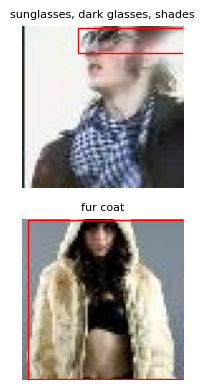

In [9]:
display_images(rsample_images(2))

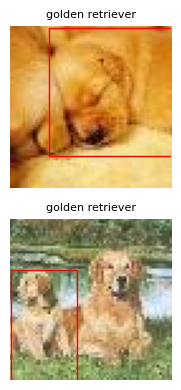

In [10]:
display_images(sample_images_by_wnid('n02099601',2))

In [17]:
# Here's how you can create a DataLoader for your dataset. Remember, this code won't run in this environment but you can use it as a template in your local environment:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to range [-1, 1]
])

# Load Tiny ImageNet dataset
train_dataset = datasets.ImageFolder(root='./tiny-imagenet-200/train', transform=transform)
val_dataset = datasets.ImageFolder(root='./tiny-imagenet-200/val', transform=transform)

# Create data loaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # Input channels = 3, output channels = 6, kernel size = 5
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 max pooling
        self.conv2 = nn.Conv2d(6, 16, 5)  # Input channels = 6, output channels = 16, kernel size = 5
        self.fc1 = nn.Linear(16 * 13 * 13, 120)  # Fully connected layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 200)  # 200 output classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Convolution -> ReLU -> Pooling
        x = self.pool(F.relu(self.conv2(x)))  # Convolution -> ReLU -> Pooling
        x = x.view(-1, 16 * 13 * 13)  # Flatten the tensor
        x = F.relu(self.fc1(x))  # Fully connected -> ReLU
        x = F.relu(self.fc2(x))  # Fully connected -> ReLU
        x = self.fc3(x)  # Fully connected
        return x


In [21]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.to(device)
    model.train()  # Set the model to training mode
    total_step = len(train_loader)
    loss_list = []
    acc_list = []

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            # Run the forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_list.append(loss.item())

            # Backprop and perform optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track the accuracy
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)

            if (i + 1) % 100 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_step}], Loss: {loss.item():.4f}, Accuracy: {100*(correct / total):.2f}%')

        print(f'End of Epoch [{epoch + 1}/{num_epochs}], Loss: {np.mean(loss_list):.4f}, Accuracy: {100*np.mean(acc_list):.2f}%')
        loss_list = []
        acc_list = []

In [22]:
# Initialize a fresh cnn-model with Cross Entropy Loss
cnn_model = SimpleCNN()
criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent as the optimizer for our CNN
optimizer = optim.SGD(cnn_model.parameters(), lr=0.01, momentum=0.9)
num_epochs = 30
train_model(cnn_model, train_loader, criterion, optimizer, num_epochs)


Epoch [1/30], Step [100/1000], Loss: 5.2981, Accuracy: 0.00%
Epoch [1/30], Step [200/1000], Loss: 5.3011, Accuracy: 0.00%
Epoch [1/30], Step [300/1000], Loss: 5.2913, Accuracy: 2.00%
Epoch [1/30], Step [400/1000], Loss: 5.2823, Accuracy: 0.00%
Epoch [1/30], Step [500/1000], Loss: 5.1772, Accuracy: 2.00%
Epoch [1/30], Step [600/1000], Loss: 5.1875, Accuracy: 2.00%
Epoch [1/30], Step [700/1000], Loss: 5.1168, Accuracy: 1.00%
Epoch [1/30], Step [800/1000], Loss: 5.1307, Accuracy: 2.00%
Epoch [1/30], Step [900/1000], Loss: 4.8954, Accuracy: 4.00%
Epoch [1/30], Step [1000/1000], Loss: 4.9284, Accuracy: 5.00%
End of Epoch [1/30], Loss: 5.1420, Accuracy: 1.64%
Epoch [2/30], Step [100/1000], Loss: 4.7431, Accuracy: 5.00%
Epoch [2/30], Step [200/1000], Loss: 4.8706, Accuracy: 5.00%
Epoch [2/30], Step [300/1000], Loss: 4.6654, Accuracy: 7.00%
Epoch [2/30], Step [400/1000], Loss: 4.5960, Accuracy: 6.00%
Epoch [2/30], Step [500/1000], Loss: 4.5735, Accuracy: 10.00%
Epoch [2/30], Step [600/1000], L

In [23]:
# Initialize a fresh cnn-model with Cross Entropy Loss
cnn_model = SimpleCNN()
criterion = nn.CrossEntropyLoss()

# Use Adam as the optimizer for our CNN
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
num_epochs = 30
train_model(cnn_model, train_loader, criterion, optimizer, num_epochs) # optimizer changed to adam

Epoch [1/30], Step [100/1000], Loss: 5.2216, Accuracy: 0.00%
Epoch [1/30], Step [200/1000], Loss: 5.0328, Accuracy: 3.00%
Epoch [1/30], Step [300/1000], Loss: 5.0683, Accuracy: 1.00%
Epoch [1/30], Step [400/1000], Loss: 4.6585, Accuracy: 5.00%
Epoch [1/30], Step [500/1000], Loss: 4.8049, Accuracy: 6.00%
Epoch [1/30], Step [600/1000], Loss: 4.6697, Accuracy: 4.00%
Epoch [1/30], Step [700/1000], Loss: 4.6001, Accuracy: 3.00%
Epoch [1/30], Step [800/1000], Loss: 4.4698, Accuracy: 9.00%
Epoch [1/30], Step [900/1000], Loss: 4.4237, Accuracy: 5.00%
Epoch [1/30], Step [1000/1000], Loss: 4.3899, Accuracy: 6.00%
End of Epoch [1/30], Loss: 4.7938, Accuracy: 4.42%
Epoch [2/30], Step [100/1000], Loss: 4.5050, Accuracy: 6.00%
Epoch [2/30], Step [200/1000], Loss: 3.9216, Accuracy: 16.00%
Epoch [2/30], Step [300/1000], Loss: 4.1010, Accuracy: 17.00%
Epoch [2/30], Step [400/1000], Loss: 4.3378, Accuracy: 11.00%
Epoch [2/30], Step [500/1000], Loss: 4.2571, Accuracy: 13.00%
Epoch [2/30], Step [600/1000]

#### Observations:
Notice how much faster `optim.Adam(lr=0.001)` converges at first compared to `optim.SGD(lr=0.01)`!

Note: We still have yet to validate these trained models. They could still just be overfitting to gain accuracy, we will need to investigate these trained models results on the val dataset!

I tried to run Adam at lr=0.01 but it wouldn't converge at all.

Running for 30 epochs each on my MacBook Air w/ M1 chip takes 48 minutes.

Time to move to the Nvidia 4090

Running for 30 epochs each on my Nvidia 4090 GPU takes 14 minutes with SGD and 12 minutes with Adam.

Each time `optim.Adam(lr=0.001)` seemed slow to reach similar accuracies that `optim.SGD(lr=0.01)` was making.